Import all Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.layers import GRU, BatchNormalization, Dropout, Dense, Bidirectional, Input, Attention, concatenate, LayerNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import GRU, Dense, BatchNormalization, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint



Import NBA Dataset and Conduct EDA

In [2]:
file_path = '/nbadataw-date.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert the date to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Extract features from the date
data['YEAR'] = data['DATE'].dt.year
data['MONTH'] = data['DATE'].dt.month
data['DAY'] = data['DATE'].dt.day
data['DAY_OF_WEEK'] = data['DATE'].dt.dayofweek
data['WEEKEND'] = data['DATE'].dt.dayofweek >= 5

# Define features and target
features = ['SALARY','FGM', 'PTS', 'AGE', 'MIN', 'FG3M', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PLUS_MINUS', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'WEEKEND']


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85129 entries, 0 to 85128
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   GAME_ID            85129 non-null  int64         
 1   DATE               85129 non-null  datetime64[ns]
 2   TEAM_ID            85129 non-null  int64         
 3   TEAM_ABBREVIATION  85129 non-null  object        
 4   TEAM_CITY          85129 non-null  object        
 5   PLAYER_ID          85129 non-null  int64         
 6   PLAYER_NAME        85129 non-null  object        
 7   SALARY             85129 non-null  int64         
 8   AGE                85129 non-null  int64         
 9   MIN                85129 non-null  float64       
 10  FGM                85129 non-null  int64         
 11  FGA                85129 non-null  int64         
 12  FG_PCT             85129 non-null  float64       
 13  FG3M               85129 non-null  int64         
 14  FG3A  

count      85129
mean     8958234
std      9879019
min         5849
25%      2033160
50%      4670160
75%     12420000
max     48070014
Name: SALARY, dtype: float64


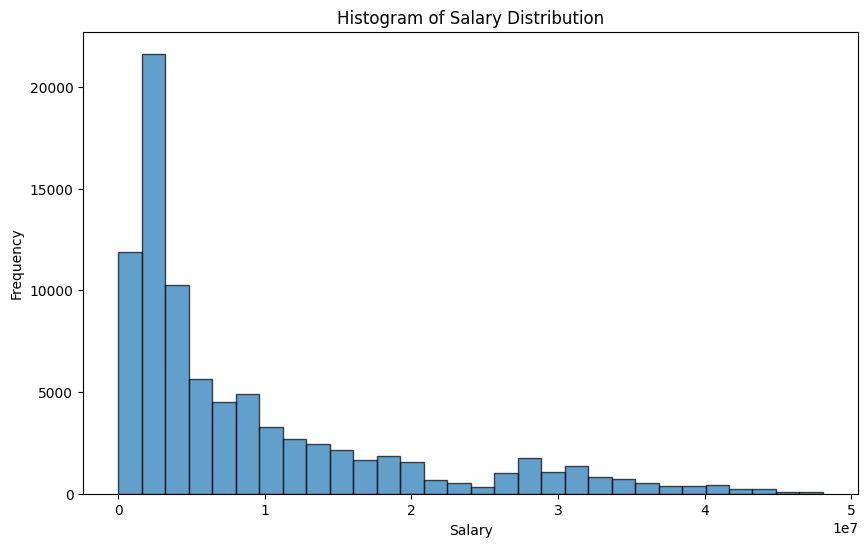

In [4]:
#Summary statistics for salary
pd.set_option('display.float_format', lambda x: '%.0f' % x)
print(data['SALARY'].describe())

plt.figure(figsize=(10, 6))
plt.hist(data['SALARY'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Histogram of Salary Distribution')
plt.show()


Text(0.5, 1.0, 'League Stats Correlations')

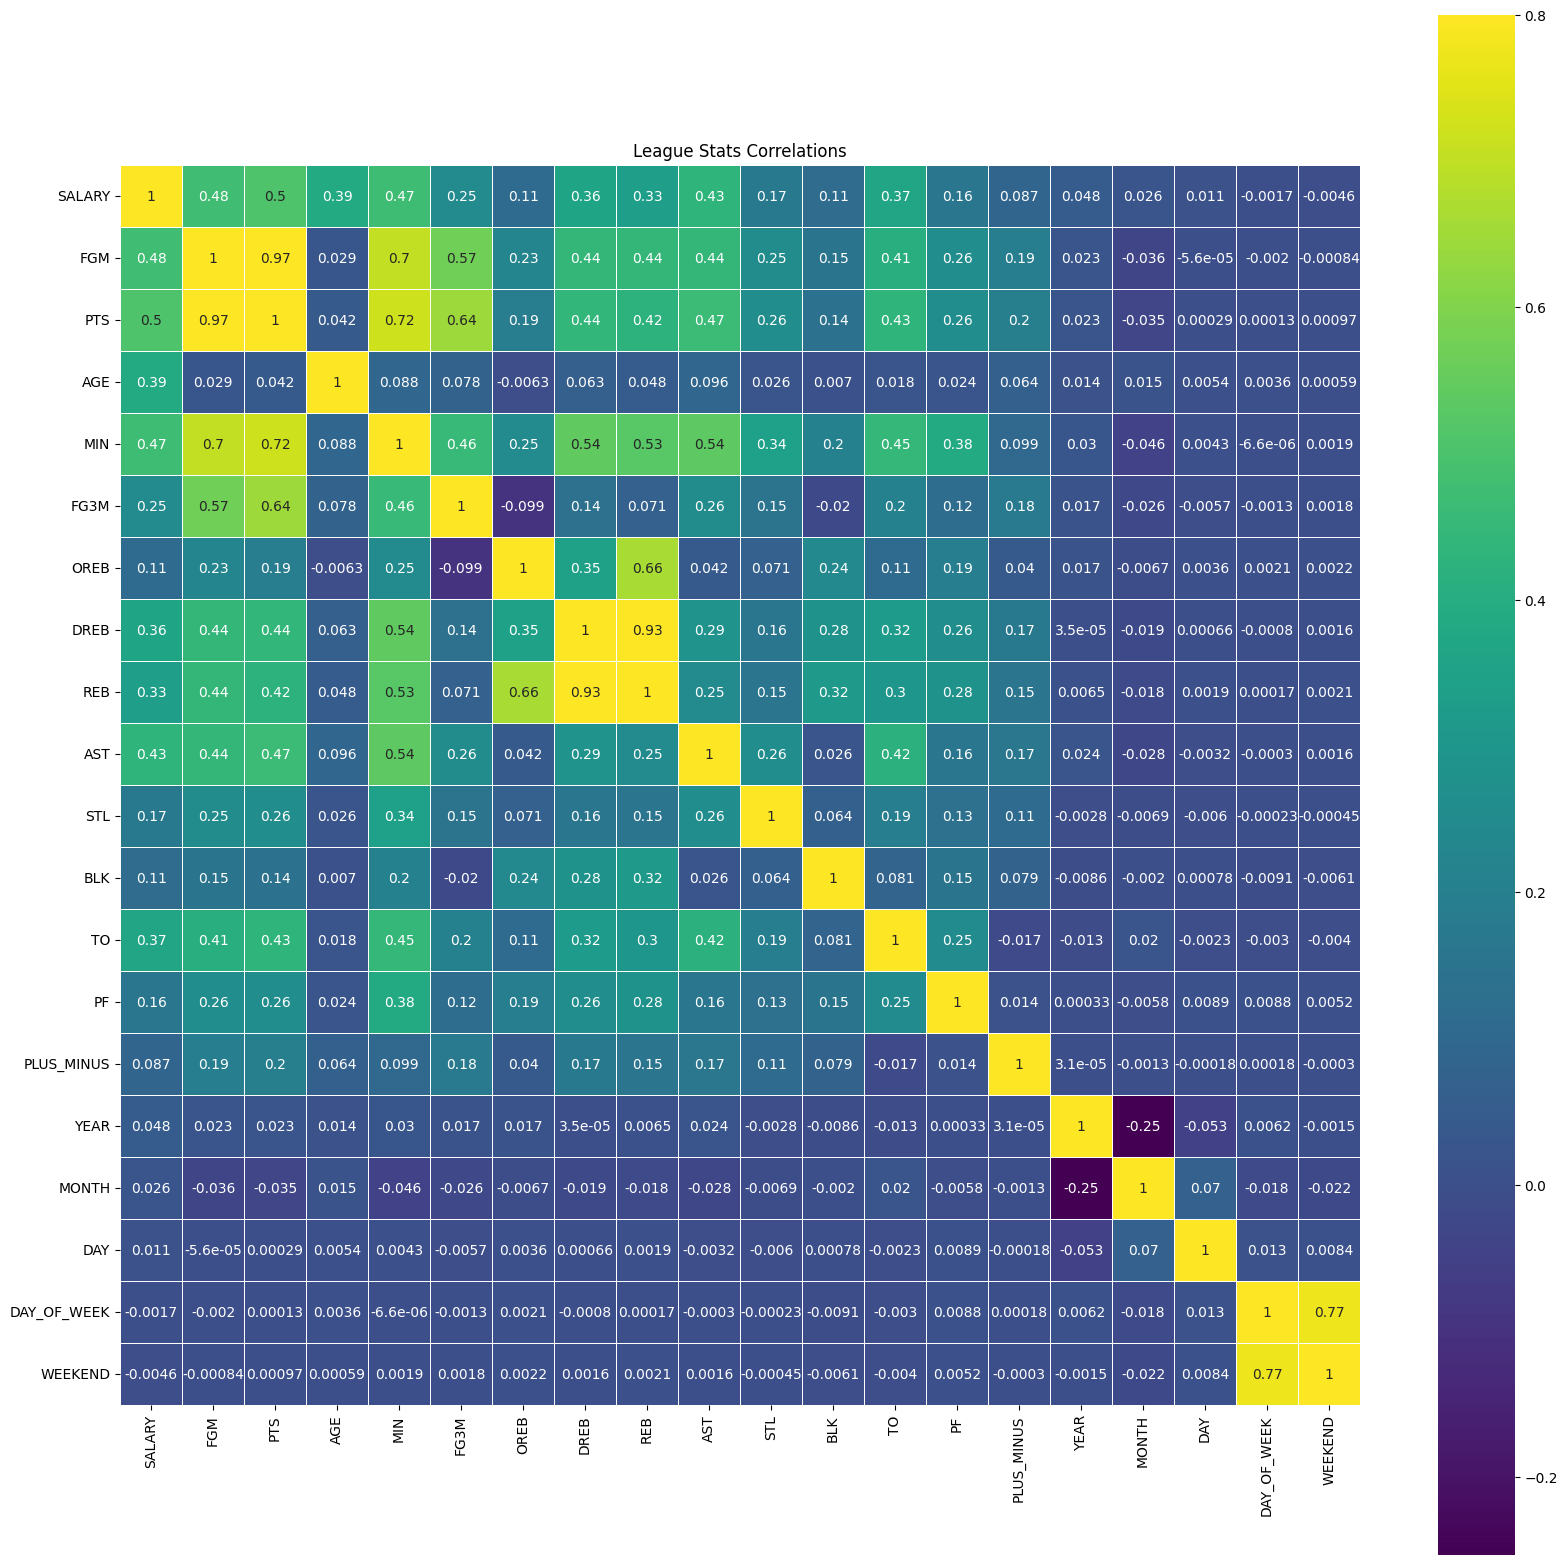

In [5]:
#Find correlations between the factors. Specifically looking for relationships with the Performance indicators and Salary

columns = ['SALARY','FGM', 'PTS', 'AGE', 'MIN', 'FG3M', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PLUS_MINUS', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'WEEKEND']
data = data[columns]

data.corr()

corrmat = data.corr()

f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap='viridis', linewidths=.5 )
plt.title('League Stats Correlations')

        Feature  Importance
2           AGE           0
1           PTS           0
3           MIN           0
8           AST           0
13   PLUS_MINUS           0
16          DAY           0
11           TO           0
6          DREB           0
7           REB           0
15        MONTH           0
4          FG3M           0
12           PF           0
14         YEAR           0
17  DAY_OF_WEEK           0
0           FGM           0
5          OREB           0
9           STL           0
10          BLK           0
18      WEEKEND           0


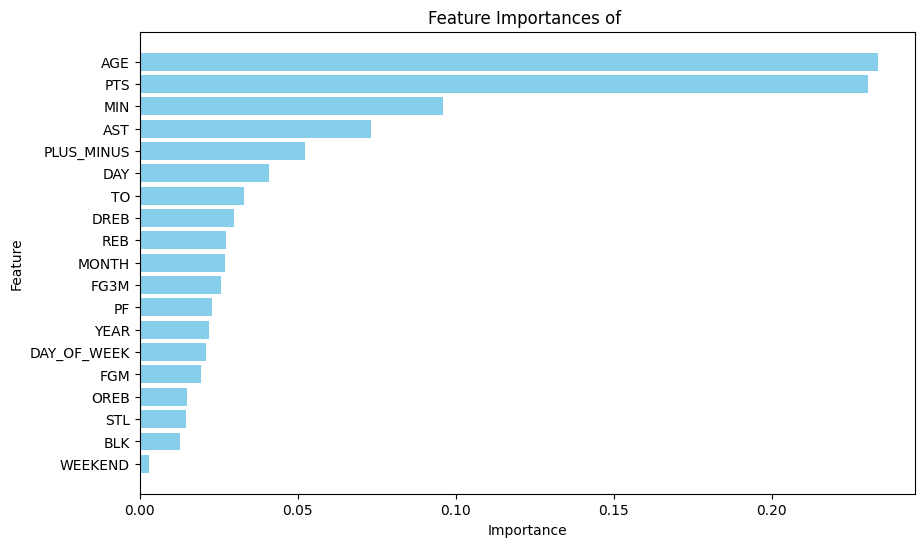

In [6]:
# Select Salary as target feature and run a Random Forest Model to determine feature importance to Salary. Then plot.
# Define features and target

features = ['FGM', 'PTS', 'AGE', 'MIN', 'FG3M', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PLUS_MINUS', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'WEEKEND']
target = 'SALARY'

X = data[features]
y = data[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

pd.reset_option('display.float_format')

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of ')
plt.gca().invert_yaxis()
plt.show()

Create Clusters from the Data to Create Salary Bins

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


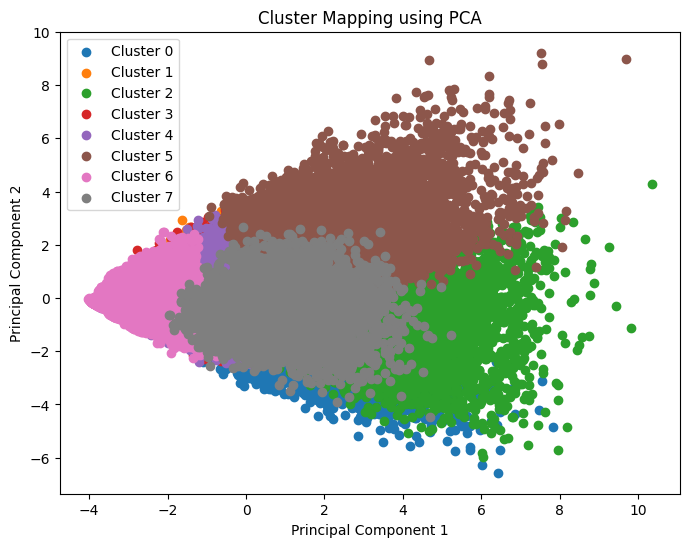

Cluster
6    16902
1    14766
4    11877
0     9878
3     9568
5     8163
7     7153
2     6822
Name: count, dtype: int64


In [7]:
#Use selected features > .02 importance for the clusters to start. #We need to normalize the features to transform them into a common scale. Then we apply K-means clustering to create the clusters.
#Apply PCA to reduce dimensions and then plot.

features = ['FGM', 'PTS', 'AGE', 'MIN', 'FG3M', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PLUS_MINUS', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK']
X = data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Mapping using PCA')
plt.legend()
plt.show()

data['Cluster'] = clusters
print(data['Cluster'].value_counts())


In [8]:
#Look at salary means for each bin and then define salary bins based on these means. We needed to change continous data into discrete bins.
#We need to encode and transform the salaries because when we put them in bins this "categorized" them.
#Display new salary classes boundaries and distribution

cluster_salary_means = data.groupby('Cluster')['SALARY'].mean().sort_values()
print(cluster_salary_means)

bins = [0] + cluster_salary_means.values.tolist() + [data['SALARY'].max()]
labels = [f'Bin{i}' for i in range(1, len(bins))]

data['SALARY_BINNED'] = pd.cut(data['SALARY'], bins=bins, labels=labels, include_lowest=True)

label_encoder = LabelEncoder()
data['SALARY_BINNED'] = label_encoder.fit_transform(data['SALARY_BINNED'])
y = to_categorical(data['SALARY_BINNED'])

num_classes = y.shape[1]
print(f'Number of classes: {num_classes}')

print(data['SALARY_BINNED'].value_counts())

for i, (bin_label, bin_range) in enumerate(zip(labels, bins[1:])):
    print(f"Bin {i+1}: <= {round(bin_range)}")

Cluster
6    2.943618e+06
1    5.519725e+06
3    6.601103e+06
4    9.381776e+06
7    1.088427e+07
5    1.224511e+07
0    1.280642e+07
2    2.234647e+07
Name: SALARY, dtype: float64
Number of classes: 9
SALARY_BINNED
0    31914
1    15346
7    10396
8     9992
3     7967
4     3665
2     2756
5     2016
6     1077
Name: count, dtype: int64
Bin 1: <= 2943618
Bin 2: <= 5519725
Bin 3: <= 6601103
Bin 4: <= 9381776
Bin 5: <= 10884266
Bin 6: <= 12245113
Bin 7: <= 12806425
Bin 8: <= 22346472
Bin 9: <= 48070014


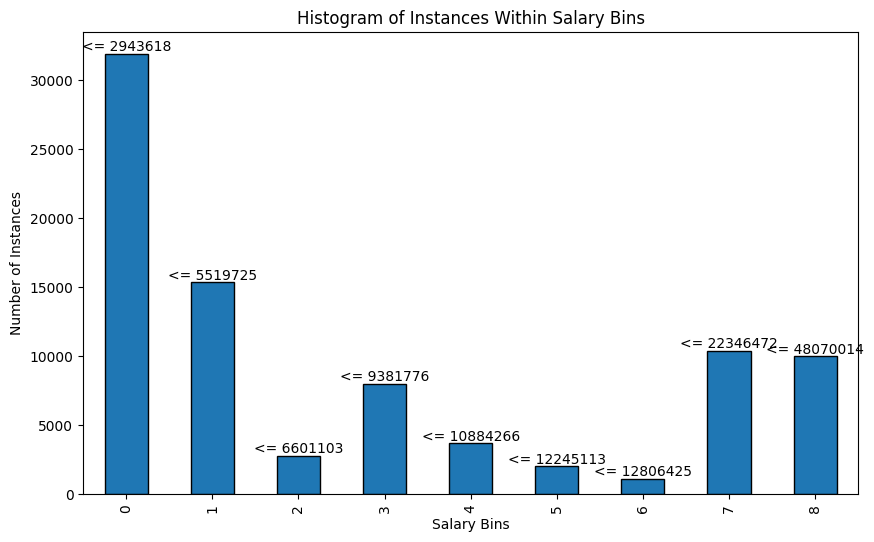

In [9]:
# Plot the  histogram of the salary bins and boundaries
plt.figure(figsize=(10, 6))
ax = data['SALARY_BINNED'].value_counts().sort_index().plot(kind='bar', edgecolor='k')
plt.xlabel('Salary Bins')
plt.ylabel('Number of Instances')
plt.title('Histogram of Instances Within Salary Bins')

for i, (bin_label, bin_range) in enumerate(zip(labels, bins[1:])):
    ax.text(i, data['SALARY_BINNED'].value_counts().sort_index()[i], f'<= {round(bin_range)}', ha='center', va='bottom')


Run the RNN GRU Classification Model with the new Salary Clusters

In [10]:

#We need to transform the features for the model and split the data into a training and testing set. Later on, we will also be splitting the training data into two with a validation set
#Then we reshape the data to be 3D and build the model, compile it, traininig it, and evaluating it on test data.

start_time = time.time()

X = scaler.fit_transform(data[features].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(512, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(num_classes, activation='softmax'))


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[reduce_lr, early_stopping, model_checkpoint], verbose=2)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {acc}')

end_time = time.time()
elapsed_time = end_time - start_time

Epoch 1/200
852/852 - 61s - loss: 1.6419 - accuracy: 0.4667 - val_loss: 1.4378 - val_accuracy: 0.4901 - lr: 0.0010 - 61s/epoch - 72ms/step
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


852/852 - 49s - loss: 1.4324 - accuracy: 0.4898 - val_loss: 1.4163 - val_accuracy: 0.4896 - lr: 0.0010 - 49s/epoch - 58ms/step
Epoch 3/200
852/852 - 49s - loss: 1.4046 - accuracy: 0.4951 - val_loss: 1.3713 - val_accuracy: 0.5016 - lr: 0.0010 - 49s/epoch - 58ms/step
Epoch 4/200
852/852 - 48s - loss: 1.3823 - accuracy: 0.5005 - val_loss: 1.3634 - val_accuracy: 0.5065 - lr: 0.0010 - 48s/epoch - 56ms/step
Epoch 5/200
852/852 - 48s - loss: 1.3588 - accuracy: 0.5106 - val_loss: 1.3356 - val_accuracy: 0.5144 - lr: 0.0010 - 48s/epoch - 57ms/step
Epoch 6/200
852/852 - 51s - loss: 1.3366 - accuracy: 0.5180 - val_loss: 1.3225 - val_accuracy: 0.5212 - lr: 0.0010 - 51s/epoch - 59ms/step
Epoch 7/200
852/852 - 47s - loss: 1.3161 - accuracy: 0.5236 - val_loss: 1.3094 - val_accuracy: 0.5239 - lr: 0.0010 - 47s/epoch - 56ms/step
Epoch 8/200
852/852 - 47s - loss: 1.2877 - accuracy: 0.5345 - val_loss: 1.3021 - val_accuracy: 0.5255 - lr: 0.0010 - 47s/epoch - 55ms/step
Epoch 9/200
852/852 - 50s - loss: 1.267

In [11]:
print(f"Time taken: {elapsed_time} seconds")

Time taken: 1041.9385423660278 seconds


Evaluate the Model

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [13]:
from keras.models import Sequential, load_model

best_model = load_model('best_model.h5')

# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

print(f'''Final metrics:
Training Accuracy: {history_dict['accuracy'][-1]:.4f}, Training Loss: {history_dict['loss'][-1]:.4f},
Validation Accuracy: {history_dict['val_accuracy'][-1]:.4f}, Validation Loss: {history_dict['val_loss'][-1]:.4f},
Testing Accuracy: {test_accuracy:.4f}, Testing Loss: {test_loss:.4f}''')

533/533 [==============================] - 8s 9ms/step - loss: 1.2767 - accuracy: 0.5322
Test Loss: 1.2767016887664795
Test Accuracy: 0.5321860909461975
Final metrics:
Training Accuracy: 0.6962, Training Loss: 0.8298,
Validation Accuracy: 0.5266, Validation Loss: 1.4353,
Testing Accuracy: 0.5322, Testing Loss: 1.2767


Plot the Training and Validation Test Loss and Accuracy

<ipython-input-14-9b5183824f84>:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


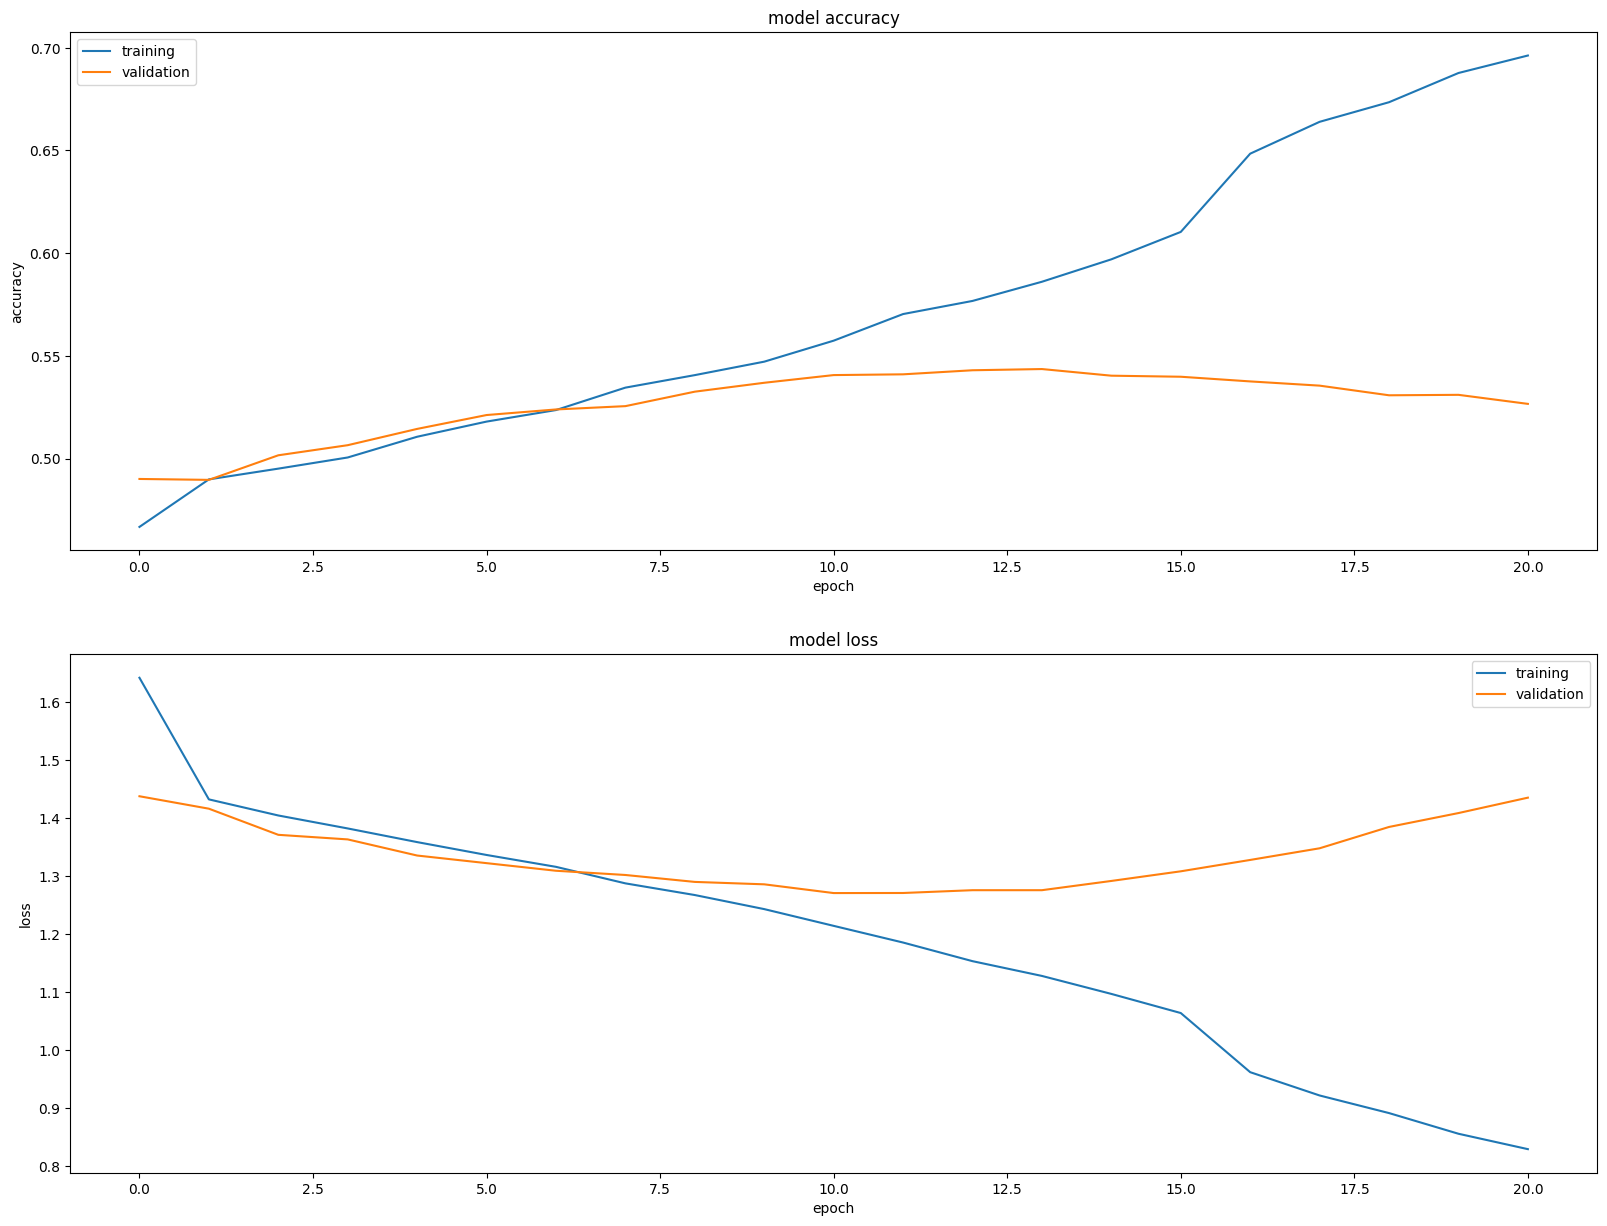

In [14]:
#Define visuals we will need

history_df = pd.DataFrame(history.history)

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

#plot training and validation loss and accuracy
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)

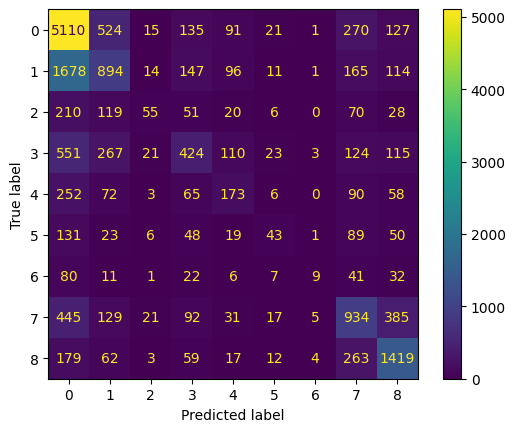

In [15]:
#Plot the Confusion Matrix

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()